In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [2]:
def nearest_neighbor_zoom(img, scale_factor):
    # Up scales image using Nearest Neighbor Interpolation.
    h, w = img.shape[:2]
    new_h, new_w = int(h * scale_factor), int(w * scale_factor)
    
    # Create grid of new coordinates
    x_new = np.arange(new_w)
    y_new = np.arange(new_h)
    
    # Map new coordinates back to old coordinates
    x_old = (x_new / scale_factor).astype(int)
    y_old = (y_new / scale_factor).astype(int)
    
    # Clip coordinates to ensure they stay within bounds
    x_old = np.clip(x_old, 0, w - 1)
    y_old = np.clip(y_old, 0, h - 1)
    
    # Use NumPy advanced indexing to pull pixels
    X, Y = np.meshgrid(x_old, y_old)
    
    zoomed_img = img[Y, X]
    return zoomed_img

In [3]:
def bilinear_zoom(img, scale_factor):
    # Upscales image using Bilinear Interpolation.
    h, w = img.shape[:2]
    new_h, new_w = int(h * scale_factor), int(w * scale_factor)

    # Map new coordinates to old coordinates (float)
    x_new = np.arange(new_w)
    y_new = np.arange(new_h)
    
    # Project to source coordinates
    src_x = x_new / scale_factor
    src_y = y_new / scale_factor
    
    # Create grid
    X_src, Y_src = np.meshgrid(src_x, src_y)
    
    # Get coordinates of the 4 neighboring pixels
    x_low = np.floor(X_src).astype(int)
    x_high = np.ceil(X_src).astype(int)
    y_low = np.floor(Y_src).astype(int)
    y_high = np.ceil(Y_src).astype(int)
    
    # Clip to bounds
    x_low = np.clip(x_low, 0, w - 1)
    x_high = np.clip(x_high, 0, w - 1)
    y_low = np.clip(y_low, 0, h - 1)
    y_high = np.clip(y_high, 0, h - 1)
    
    # Calculate weights (distance from the integer coordinate)
    x_weight = X_src - x_low
    y_weight = Y_src - y_low
    
    # Expand dims for broadcasting if image is color (H, W, 3)
    if len(img.shape) == 3:
        x_weight = np.expand_dims(x_weight, 2)
        y_weight = np.expand_dims(y_weight, 2)

    # Get pixel values at corners
    Ia = img[y_low, x_low]
    Ib = img[y_low, x_high]
    Ic = img[y_high, x_low]
    Id = img[y_high, x_high]
    
    # Interpolate
    top = Ia * (1 - x_weight) + Ib * x_weight
    bottom = Ic * (1 - x_weight) + Id * x_weight
    
    # Final blend vertical
    zoomed_img = top * (1 - y_weight) + bottom * y_weight
    
    return zoomed_img.astype(np.uint8)

In [4]:
def compute_ssd(img1, img2):
    # Computes Normalized Sum of Squared Difference (SSD).
    
    # Ensure images are same size
    if img1.shape != img2.shape:
        # Resize img2 to match img1 just for metric calculation if slight off-by-one error
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
        
    diff = img1.astype(np.float64) - img2.astype(np.float64)
    ssd = np.sum(diff ** 2)
    
    # Normalize by total number of pixels
    normalized_ssd = ssd / (img1.shape[0] * img1.shape[1])
    return normalized_ssd

In [5]:
def process_zoom_images(input_dir, output_dir):
    """
    Matches small images to originals, upscales them, computes SSD, and plots results.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Get all files
    all_files = glob.glob(os.path.join(input_dir, '*'))
    
    # Identify target "small" images
    small_files = [f for f in all_files if 'small' in os.path.basename(f).lower()]
    
    print(f"Found {len(small_files)} test images to process.\n")

    for small_path in small_files:
        filename = os.path.basename(small_path)
        name_no_ext, ext = os.path.splitext(filename)
        
        # --- 1. Derive Original Filename ---
        if '_very_small' in name_no_ext:
            original_name = name_no_ext.replace('_very_small', '') + ext
        elif '_small' in name_no_ext:
            original_name = name_no_ext.replace('_small', '') + ext
        elif 'small' in name_no_ext:
            original_name = name_no_ext.replace('small', '') + ext
        else:
            print(f"Skipping {filename}: Naming pattern unrecognized.")
            continue
            
        original_path = os.path.join(input_dir, original_name)

        # --- 2. Check Existence & Load ---
        if not os.path.exists(original_path):
            print(f"Skipping {filename}: Original '{original_name}' not found.")
            continue

        img_small = cv2.imread(small_path)
        img_orig = cv2.imread(original_path)
        
        if img_small is None or img_orig is None:
            print(f"Error loading {filename}")
            continue

        # --- 3. Process ---
        # Calculate Scale Factor (Width Original / Width Small)
        scale_factor = img_orig.shape[1] / img_small.shape[1]
        print(f"Processing: {filename} -> Original: {original_name} (Scale: {scale_factor:.2f}x)")

        # Upscale
        nn_zoomed = nearest_neighbor_zoom(img_small, scale_factor)
        bi_zoomed = bilinear_zoom(img_small, scale_factor)
        
        # Handle slight size mismatches due to rounding
        if nn_zoomed.shape != img_orig.shape:
             img_orig_resized = cv2.resize(img_orig, (nn_zoomed.shape[1], nn_zoomed.shape[0]))
        else:
             img_orig_resized = img_orig

        # Compute SSD
        ssd_nn = compute_ssd(img_orig_resized, nn_zoomed)
        ssd_bi = compute_ssd(img_orig_resized, bi_zoomed)
        
        print(f"  SSD (Nearest Neighbor): {ssd_nn:.2f}")
        print(f"  SSD (Bilinear)        : {ssd_bi:.2f}")
        
        # Save Outputs
        cv2.imwrite(os.path.join(output_dir, f"{name_no_ext}_nn.jpg"), nn_zoomed)
        cv2.imwrite(os.path.join(output_dir, f"{name_no_ext}_bi.jpg"), bi_zoomed)

        # --- 4. Visualization (Plotting) ---
        plt.figure(figsize=(15, 6))
        
        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(img_orig_resized, cv2.COLOR_BGR2RGB))
        plt.title(f'Original: {original_name}')
        plt.axis('off')
        
        # Nearest Neighbor Result
        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(nn_zoomed, cv2.COLOR_BGR2RGB))
        plt.title(f'Nearest Neighbor\nSSD: {ssd_nn:.2f}')
        plt.axis('off')
        
        # Bilinear Result
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(bi_zoomed, cv2.COLOR_BGR2RGB))
        plt.title(f'Bilinear\nSSD: {ssd_bi:.2f}')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        print("-" * 50) # Separator line

    print("\nBatch processing complete.")

Found 5 test images to process.

Processing: im01small.png -> Original: im01.png (Scale: 4.00x)
  SSD (Nearest Neighbor): 408.81
  SSD (Bilinear)        : 600.74


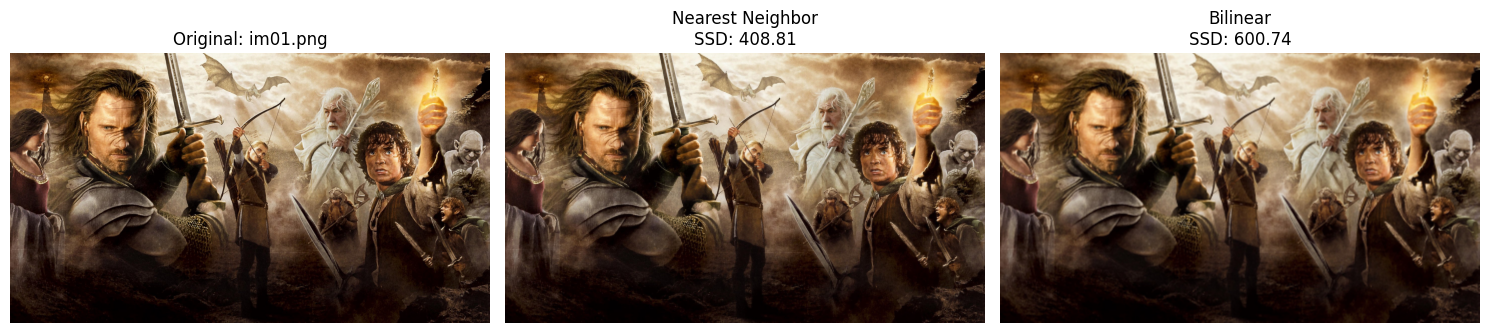

--------------------------------------------------
Processing: im02small.png -> Original: im02.png (Scale: 4.00x)
  SSD (Nearest Neighbor): 79.34
  SSD (Bilinear)        : 146.88


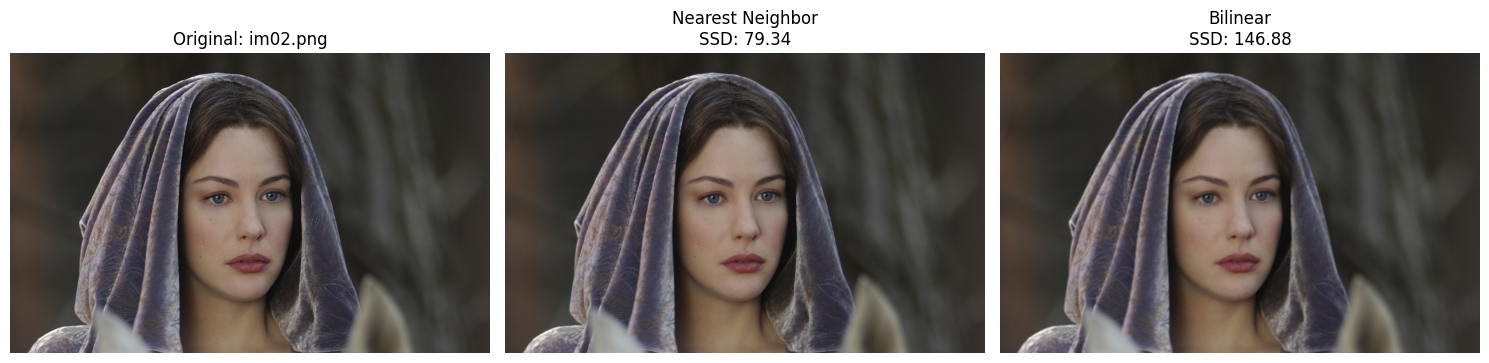

--------------------------------------------------
Processing: im03small.png -> Original: im03.png (Scale: 4.00x)
  SSD (Nearest Neighbor): 190.21
  SSD (Bilinear)        : 330.27


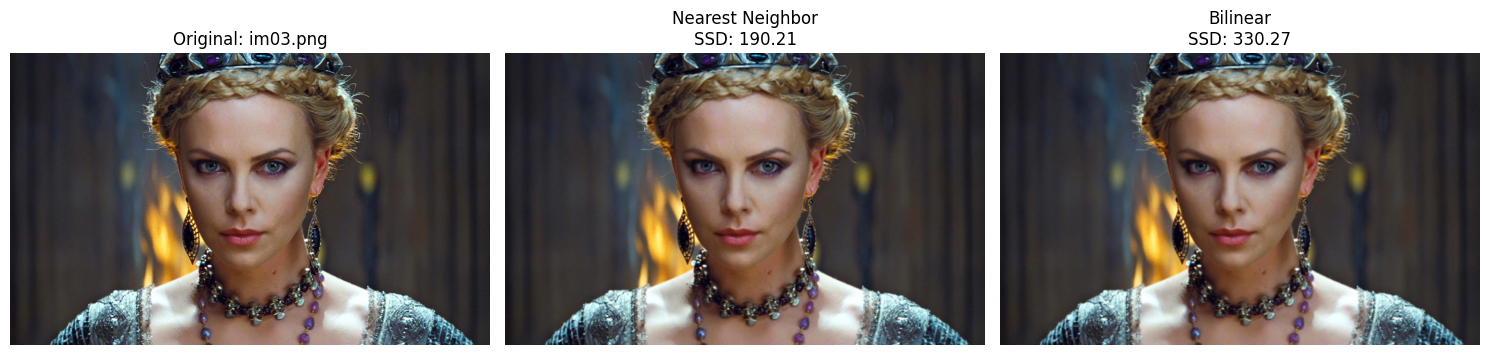

--------------------------------------------------
Processing: taylor_small.jpg -> Original: taylor.jpg (Scale: 5.00x)
  SSD (Nearest Neighbor): 714.08
  SSD (Bilinear)        : 855.42


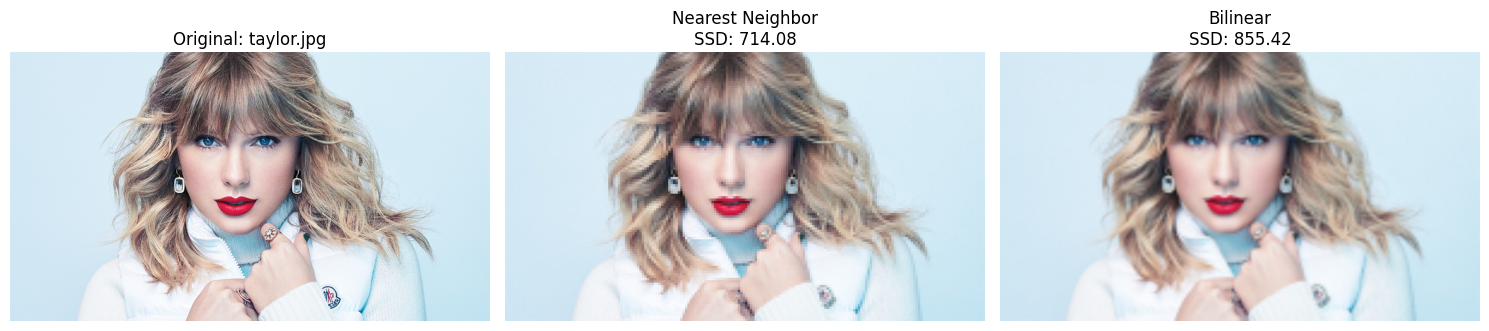

--------------------------------------------------
Processing: taylor_very_small.jpg -> Original: taylor.jpg (Scale: 20.00x)
  SSD (Nearest Neighbor): 1457.67
  SSD (Bilinear)        : 1963.79


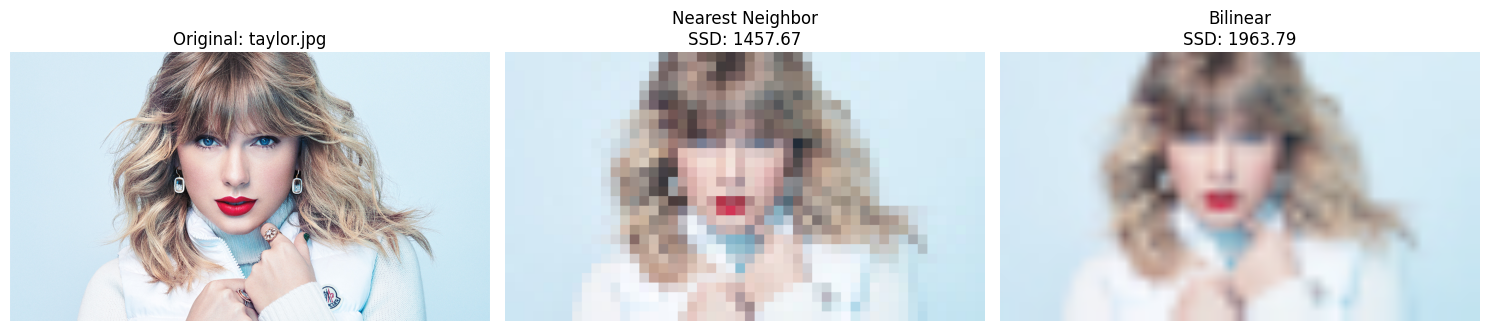

--------------------------------------------------

Batch processing complete.


In [6]:
input_folder = '../images/a1q7images' 
output_folder = '../images/outputs/q7_results'

process_zoom_images(input_folder, output_folder)